In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from scipy.io import loadmat
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact, interactive, interactive_output
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import ipywidgets as widgets
import scipy
import matplotlib
import sklearn
from IPython.display import clear_output, display
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import chi2_contingency, ttest_ind,ttest_1samp, spearmanr
                 
from tempfile import TemporaryFile
from random import randint
#import networkx as nx
#from pyvis.network import Network

import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

np.random.seed(42)


In [2]:
# define config
class structtype():
    pass

config = structtype()
config.deploy_flag = 0

def set_axis_defaults():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# define cat variable labels
labels = {'cl': ["2/3", "4a/b", "4cα", "4cβ", "5", "6", "WM"], 
         'sc': ["Com.", "Sim."],
         'ct': ["AS", "FS", "RM", "RL"]}

In [3]:
def make_cont_mtx(cat_row, cat_col, cont, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    cont_mtx = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            cont_mtx[idxr, idxc] = np.nanmean(cont[np.logical_and(cat_row == row,cat_col == col)]);
    return cont_mtx;

def make_prop_mtx(cat_row, cat_col, numer_var, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    prop_numer = np.zeros((cat_rows.size, cat_cols.size))
    prop_denom = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            subset = np.logical_and(cat_row == row,cat_col == col)
            rev_subset = np.logical_and(cat_row == col, cat_col == row)
            either_subset = np.logical_or(subset, rev_subset)
            prop_numer[idxr, idxc] = np.nansum(numer_var[subset])
            prop_denom[idxr, idxc] = np.size(numer_var[subset])
            
    prop_mtx = np.divide(prop_numer, prop_denom)
    return prop_mtx, prop_numer, prop_denom

In [4]:
ccg_data = loadmat('output/19-Aug-2021/ccg_attributes_large_.mat', chars_as_strings=True)
ccg_data = ccg_data['ccg_data'][0][0]

In [5]:
# analysis functions
def von_mises(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*np.exp(a_2*(np.cos(2*x-2*a_3)-1))

def fit_von_mises(ydata):
    xdata = np.linspace(0, 2*np.pi, 36)
    popt, pcov = scipy.optimize.curve_fit(von_mises, xdata, ydata, maxfev=100000)
    return np.rad2deg(xdata), von_mises(xdata,*popt)

In [20]:
def plot_figure1(ccg_curr,ccg_curr_half, ccg_all, ids):
    ids = np.array(ids) + 1 # because 1 indexing for examples
    # plot 1 good example ccg (full range)
    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[0], ccg_curr['post_id']==ids[1])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    ex_ccg_jitter = ccg_curr['ccg_jitter'][ex_id]
    ex_ccg_norm = ccg_curr['ccg_norm'][ex_id]

    for i in range(4):
        plt.figure(figsize=(2,2.66))
        if i >=0:
            plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_norm), color='#B2BEB5')
        if i>=1:
            plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_jitter), color='#71797E')
        if i>=2:
            plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
        if i>=3:
            plt.fill_between(x=[-100, -50],y1=-0.005, y2=0.005, color="#d4d4d4")
        leg = ["Uncorrected CCG", "Jittered CCG","Corrected CCG", "Noise Distribution"]
        plt.legend(leg[0:i+1], frameon=False, fontsize=8)
        plt.vlines(0,-0.01,0.05, color='k', linestyle='dotted')
        
        if i>=3:
            plt.fill_between(x=[50, 100],y1=-0.005, y2=0.005, color="#d4d4d4")

        plt.xlim((-100, 100))
        plt.ylim(-0.01, 0.09)
        plt.xlabel('time lag (ms)')
        plt.ylabel('efficacy (coincidences/spike)')
        rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
        set_axis_defaults()
        plt.savefig('figures/prez/fig1_ex_ccg' + str(i) + '.svg', dpi=300, bbox_inches='tight')
        plt.show()

    # plot dist. of noise_std vs # sig pairs 
    noise_std_above_mean = np.squeeze((ccg_all['peaks']-ccg_all['noise_mean2'])/ccg_all['noise_std2'])
    noise_std_above_mean = noise_std_above_mean[::2] # only select 1 direction of ccgs so that we are not double counting
    
    total_pairs = noise_std_above_mean.size
    pairs_within_10 = np.sum(np.logical_and(np.squeeze(ccg_all['peak_lag'][::2])>=-10, np.squeeze(ccg_all['peak_lag'][::2])<=10))

    noise_std_above_mean = noise_std_above_mean[np.logical_and.reduce((~np.isinf(noise_std_above_mean),
                                                                      ~np.isnan(noise_std_above_mean), 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])>=-10, 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])<=10))]

    plt.figure(figsize=(2,2.66))
    ecdf_calc = []
    for i in np.arange(7,20.1,.1):
            ecdf_calc.append(np.sum(noise_std_above_mean>i))
            
    sns.ecdfplot(x=noise_std_above_mean, stat='count', complementary=True, color='k')
    plt.xlim(0, 20)
    plt.ylabel("num. of pairs")
    plt.xlabel("peak > x std. above noise")
    plt.axvline(7, color='k', linestyle='solid')
    plt.gca().text(10, 20000,'all, n = ' + str(int(total_pairs)) + '\n'+
                   '|lag|<=10, n = ' + str(int(pairs_within_10)) + '\n'+
                   'sig., n = ' + str(int(np.sum(noise_std_above_mean>7))))
    plt.fill_between(np.arange(7,20.1,.1), ecdf_calc,color='#15E6CD' )
    set_axis_defaults()
    plt.savefig('figures/prez/fig1_sig_cdf.svg', dpi=300, bbox_inches='tight')
    plt.show()

    
def plot_figure1_ex_ccgs(ccg_curr, ids, cols):
    ids = np.array(ids) + 1 # because 1 indexing for examples
    # plot 1 good example ccg (full range)
    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[0], ccg_curr['post_id']==ids[1])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
    plt.axvline(0, color='k', linestyle='dotted')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidences/spike)')
    rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
    plt.gca().text(10, .015,'lag = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms \npeak = "+ str(rounded_peak))
    plt.gca().text(-57, .008,'neuron 3\nleads', horizontalAlignment='center', color=cols[0], size=10)
    plt.gca().text(60, .008,'neuron 4\nleads', horizontalAlignment='center', color=cols[1], size=10)
    set_axis_defaults()
    plt.savefig('figures/prez/fig1_ex_ccg_sim.svg', dpi=300, bbox_inches='tight')
    plt.show()

    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[2], ccg_curr['post_id']==ids[3])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
    plt.axvline(0, color='k', linestyle='dotted')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidences/spike)')

    rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
    plt.gca().text(10, .015,'lag = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms \npeak = "+ str(rounded_peak))
    plt.gca().text(-57, .008,'neuron 1\nleads', horizontalAlignment='center', color=cols[2], size=10)
    plt.gca().text(60, .008,'neuron 2\nleads', horizontalAlignment='center', color=cols[3], size=10)

    set_axis_defaults()
    plt.savefig('figures/prez/fig1_ex_ccg_dif.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_figure2(ccg_curr_half):
    # lag -> color
    # peak -> line width 

    data = pd.DataFrame({"med. peak": np.squeeze((ccg_curr_half['peaks'])),
                  "avg. |time lag| (ms)": np.squeeze(np.abs(ccg_curr_half['peak_lag'])),
                  "vert. pair distance ($\mu$m)": np.squeeze(ccg_curr_half['pair_distance']),
                  "$r_{ori}$": np.squeeze(ccg_curr_half['r_ori']), "put. cell type": np.squeeze(ccg_curr_half['pre_sc'])})

    #pair_grid = sns.pairplot(data, hue="put. cell type", corner=True, diag_kws={'common_norm': True},plot_kws={'scatter_kws':{'s':.5}})
    y = "avg. |time lag| (ms)"
    x = "vert. pair distance ($\mu$m)"
    r, p = spearmanr(data[x],data[y])

    g = sns.JointGrid(data=data, x=x, y=y, size=4)
    g.plot_joint(sns.regplot,data=data, order=2,x_bins=10,fit_reg = False, color='k', truncate=True)
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()
    sns.kdeplot(y=y, data=data, ax=g.ax_marg_y, fill=False, color='#15E6CD', linewidth=2)
    sns.kdeplot(x=x, data=data,  ax=g.ax_marg_x, fill=False, color='#15E6CD', linewidth=2)
    g.ax_joint.get_shared_y_axes().remove(g.ax_joint)
    g.ax_joint.get_shared_x_axes().remove(g.ax_joint)
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    plt.sca(g.ax_joint)

    plt.gca().text(.6,.1,'$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p),transform = plt.gca().transAxes)
    set_axis_defaults()
    plt.gca().set_xlim(0,1500)
    plt.savefig('figures/prez/fig2_lag_vs_pd.svg', dpi=300, bbox_inches='tight')
    plt.show()




    y = "avg. |time lag| (ms)"
    x = "$r_{ori}$"
    r, p = spearmanr(data[x],data[y])

    g = sns.JointGrid(data=data, x=x, y=y, size=4)
    g.plot_joint(sns.regplot,data=data, order=2,x_bins=10,fit_reg = False, color='k', truncate=True)
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()
    sns.kdeplot(y=y, data=data, ax=g.ax_marg_y, fill=False, color='#15E6CD', linewidth=2)
    sns.kdeplot(x=x, data=data,  ax=g.ax_marg_x, fill=False, color='#15E6CD', linewidth=2)
    g.ax_joint.get_shared_y_axes().remove(g.ax_joint)
    g.ax_joint.get_shared_x_axes().remove(g.ax_joint)
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    plt.sca(g.ax_joint)
    plt.gca().text(.6,.7, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p),transform = plt.gca().transAxes)
    set_axis_defaults()
    plt.gca().set_xlim(-.3,1)
    plt.savefig('figures/prez/fig2_lag_vs_ori.svg', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3,3))
    y = "med. peak"
    x = "vert. pair distance ($\mu$m)"
    r, p = spearmanr(data[x],data[y])

    g = sns.JointGrid(data=data, x=x, y=y, size=4)
    g.plot_joint(sns.regplot,data=data, order=2,x_bins=10,fit_reg = False, color='k',x_estimator=np.median, truncate=True)
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()
    sns.kdeplot(y=y, data=data, ax=g.ax_marg_y, fill=False, color='#15E6CD', linewidth=2)
    sns.kdeplot(x=x, data=data,  ax=g.ax_marg_x, fill=False, color='#15E6CD', linewidth=2)
    g.ax_joint.get_shared_y_axes().remove(g.ax_joint)
    g.ax_joint.get_shared_x_axes().remove(g.ax_joint)
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    plt.sca(g.ax_joint)

    plt.gca().text(.6,.7, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p),transform = plt.gca().transAxes)
    plt.gca().set_xlim(0,1500)
    plt.gca().set_ylim(0.01, 0.02)#plt.gca().get_xlim()[0], 1)
    set_axis_defaults()
    plt.savefig('figures/prez/fig2_peak_vs_pd.svg', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3,3))
    y = "med. peak"
    x = "$r_{ori}$"
    r, p = spearmanr(data[x],data[y])

    g = sns.JointGrid(data=data, x=x, y=y, size=4)
    g.plot_joint(sns.regplot,data=data, order=2,x_bins=10,fit_reg = False, color='k',x_estimator=np.median, truncate=True)
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()
    sns.kdeplot(y=y, data=data, ax=g.ax_marg_y, fill=False, color='#15E6CD', linewidth=2)
    sns.kdeplot(x=x, data=data,  ax=g.ax_marg_x, fill=False, color='#15E6CD', linewidth=2)
    g.ax_joint.get_shared_y_axes().remove(g.ax_joint)
    g.ax_joint.get_shared_x_axes().remove(g.ax_joint)
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    plt.sca(g.ax_joint)

    plt.text(.1,.7, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p),transform = plt.gca().transAxes)
    #plt.gca().set_xlim(plt.gca().get_xlim()[0], 1)
    #plt.gca().set_ylim(0.01, 0.02)#plt.gca().get_xlim()[0], 1)
    set_axis_defaults()
    plt.savefig('figures/prez/fig2_peak_vs_ori.svg', dpi=300, bbox_inches='tight')
    plt.show()

def plot_figure2_ex_tune(ccg_curr, ccg_all, ids, cols):
    sim1_col = cols[0]
    sim2_col = cols[1]
    dif1_col = cols[2]
    dif2_col = cols[3]
    sim_idx1 = ids[0]
    sim_idx2 = ids[1]
    dif_idx1 = ids[2]
    dif_idx2 = ids[3]

    ori_tuning = np.squeeze(ccg_curr['cluster'][0][0]['mean_ori_tune'])
    ses_3_tuning = ori_tuning
    ses_3_tuning = np.transpose(np.transpose(ses_3_tuning) - np.ndarray.min(ses_3_tuning, axis=1)) # subtract min, new min = 0
    one_over_range = 1/np.ptp(ses_3_tuning, axis=1)
    ses_3_tuning = ses_3_tuning*one_over_range[:,np.newaxis]     



    ori_tune_cell1 = ses_3_tuning[sim_idx1]
    ori_tune_cell2 = ses_3_tuning[sim_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)

    theta =  np.arange(0, 1+1/36, 1/36)*2*np.pi
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(1,2))
    ax.plot(theta, np.append(ori1_y, ori1_y[0]), linewidth=2, color=sim1_col)
    ax.plot(theta, np.append(ori2_y, ori2_y[0]), linewidth=2, color=sim2_col)
    ax.set_thetagrids([0,90,180,270])
    ax.set_rticks([])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.spines['polar'].set_visible(False)
    ax.set_aspect(2)
    plt.savefig('figures/prez/fig2_ex_tune_sim.svg', dpi=300, bbox_inches='tight')

    plt.show()

    ori_tune_cell1 = ses_3_tuning[dif_idx1]
    ori_tune_cell2 = ses_3_tuning[dif_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)

    theta =  np.arange(0, 1+1/36, 1/36)*2*np.pi
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(1,2))
    ax.plot(theta, np.append(ori1_y, ori1_y[0]), linewidth=2, color=dif1_col)
    ax.plot(theta, np.append(ori2_y, ori2_y[0]), linewidth=2, color=dif2_col)
    ax.set_thetagrids([0,90,180,270])
    ax.set_rticks([])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.spines['polar'].set_visible(False)
    ax.set_aspect(2)
    plt.savefig('figures/prez/fig2_ex_tune_diff.svg', dpi=300, bbox_inches='tight')

    plt.show()

    plt.figure(figsize=(2.5,2.5))

    df = pd.DataFrame({'firing rate neuron 3': ses_3_tuning[sim_idx1], 'firing rate neuron 4': ses_3_tuning[sim_idx2]})
    sns.scatterplot(data=df, x='firing rate neuron 3', y='firing rate neuron 4', color='k')
    plt.gca().text(.5, .4, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==sim_idx1+1, ccg_all['post_id']==sim_idx2+1)]),2)), fontsize=10)

    plt.xlabel(plt.gca().get_xlabel(), color=sim1_col) #, bbox={'boxstyle': 'round', 'color':'k'}
    plt.ylabel(plt.gca().get_ylabel(), color=sim2_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    set_axis_defaults()
    plt.savefig('figures/prez/fig2_ex_signal_corr_sim.svg', dpi=300, bbox_inches='tight')

    plt.show()    

    plt.figure(figsize=(2.5,2.5))
    df = pd.DataFrame({'firing rate neuron 1': ses_3_tuning[dif_idx1], 'firing rate neuron 2': ses_3_tuning[dif_idx2]})    
    sns.scatterplot(data=df, x='firing rate neuron 1', y='firing rate neuron 2', color='k')
    plt.text(.5, .8, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==dif_idx1+1, ccg_all['post_id']==dif_idx2+1)]),2)), fontsize=10)
    plt.tight_layout()

    plt.xlabel(plt.gca().get_xlabel(), color=dif1_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    plt.ylabel(plt.gca().get_ylabel(), color=dif2_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    set_axis_defaults()
    plt.savefig('figures/prez/fig2_ex_signal_corr_diff.svg', dpi=300, bbox_inches='tight')

    plt.show()    
    
def plot_figure2_network(ccg_curr_half, ids, cols):
    ccg_curr_half_t = ccg_curr_half.copy()
    session_idx = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_session'])
    depths = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celldepth'])
    med_peaks = []
    for idx in range(ccg_curr_half_t['cluster'][0][0]['Cluster_session'].size):
        med_peaks.append(np.median(ccg_curr_half_t['peaks'][np.logical_or(ccg_curr_half_t['pre_id'] == idx+1,ccg_curr_half_t['post_id'] == idx+1)]))

    cell_layer = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celllayer'])
    mean_peaks = np.array(med_peaks)
    ccg_curr = ccg_curr_half_t
    
    plt.figure(figsize=(4,6))
    np.random.default_rng(0)
    xrand = np.random.randn(*depths.shape)
    pre_x = np.ones_like(depths)+xrand/2
    cell_layer = np.array([(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in cell_layer])
    uq_ses = np.unique(session_idx)
    xdiv = 5
    xticks = []
    xticklabels = []
    
    nfive_quant = np.nanquantile(mean_peaks, .95)
    mean_peaks[mean_peaks>nfive_quant] = nfive_quant
    
    xs = np.array([])
    ys = np.array([])
    
    for i in range(uq_ses.size):
        ses_id = np.squeeze((session_idx == uq_ses[i]))
        xs = np.concatenate((xs, pre_x[ses_id] + xdiv*i))
        ys = np.concatenate((ys, depths[ses_id]))
    
    idx = np.argsort(depths)
    sns.scatterplot(x = xs, y = depths, color='k')
    #plt.plot(mean_peaks[idx]/np.nanmax(mean_peaks[idx]), depths[idx])
    #plt.legend(frameon=False, loc='lower right')
    for i in range(uq_ses.size):
        ses_id = session_idx == uq_ses[i]
        xticks.append(xdiv*i+1)
        xticklabels.append('ses. ' + str(i+1))

        if i == 2:
            for j in range(len(cols)):
                plt.scatter(pre_x[ids[j]] + xdiv*i, depths[ids[j]], color=cols[j],s=80)
            plt.plot([pre_x[ids[0]] + xdiv*i, pre_x[ids[1]] + xdiv*i],[depths[ids[0]],depths[ids[1]]], linewidth=2, color='k')
            plt.plot([pre_x[ids[2]] + xdiv*i, pre_x[ids[3]] + xdiv*i],[depths[ids[2]],depths[ids[3]]], linewidth=2, color='k')
            plt.plot([xdiv*i+4,xdiv*i+4],[depths[ids[0]],depths[ids[1]]], linestyle='--',linewidth=2, color='k')
            plt.plot([xdiv*i+4,xdiv*i+4],[depths[ids[2]],depths[ids[3]]], linestyle='--',linewidth=2, color='k')
            plt.text(xdiv*i+4.5,(depths[ids[2]]+depths[ids[3]])/2, 'p.d.=' + str(round(abs(depths[ids[2]]-depths[ids[3]])))+" $\mu m$")
            plt.text(xdiv*i+4.5,(depths[ids[0]]+depths[ids[1]])/2, 'p.d.=' + str(round(abs(depths[ids[0]]-depths[ids[1]])))+" $\mu m$")
    plt.gca().set_xlim(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]*1.4)
    ###plt.gca().legend(np.flip(np.append(labels['cl'], '_Hidden')), loc='upper right', frameon=False) 
    set_axis_defaults()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xticks(xticks)
    plt.gca().set_ylim(0,2500)
    plt.ylabel("distance from probe tip ($\mu m$)")
    plt.savefig('figures/prez/fig2_network.svg', dpi=300, bbox_inches='tight')

    plt.show()



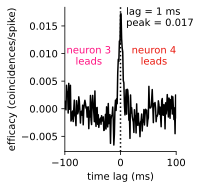

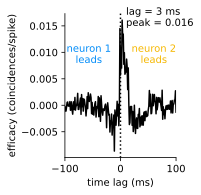

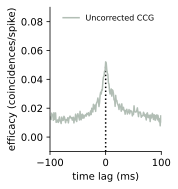

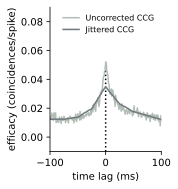

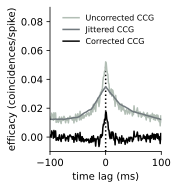

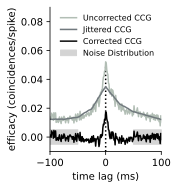

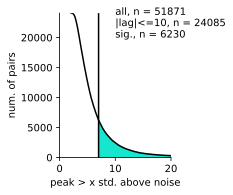

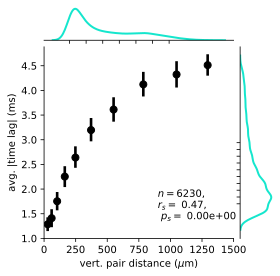

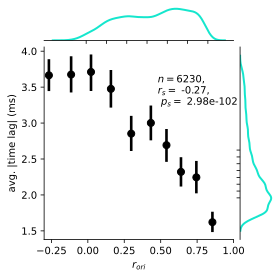

<Figure size 216x216 with 0 Axes>

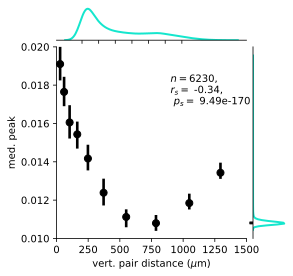

<Figure size 216x216 with 0 Axes>

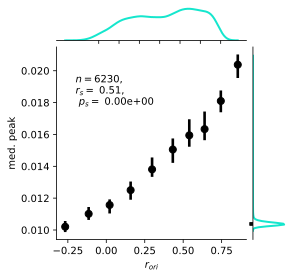

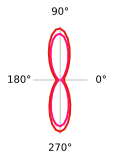

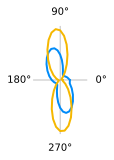

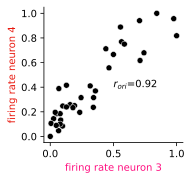

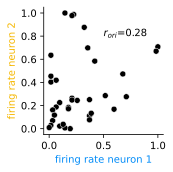

In [22]:
# paper figures/focus on siegle framing/new exclusion criteria
ccg_all = ccg_data['ccg'][0][0].copy()
ccg_curr = ccg_all.copy()
ccg_curr_half = ccg_all.copy()

noise_std = ccg_all['noise_std2']
noise_mean = ccg_all['noise_mean2']
subset = np.logical_and.reduce((noise_std>0, ccg_all['peaks']>7*noise_std + noise_mean, ccg_all['peak_lag']>=-10, ccg_all['peak_lag']<=10));

test = np.transpose((np.arange(subset.shape[0]) % 2) == 0)   
subset_half = np.logical_and(np.squeeze(subset), np.transpose(np.mod(np.arange(subset.shape[0]), 2) == 0))

ccg_fields = ccg_data['ccg'][0][0].dtype.names

for field in ccg_fields:
    if field != 'config' and field != 'cluster':
        ccg_curr[field] = ccg_all[field][np.squeeze(subset)]
        ccg_curr_half[field] = ccg_all[field][np.squeeze(subset_half)]

ids = [389, 401, 522, 542] # 378, 541
#ids = [int(ccg_curr_half['pre_id'][6230-x1])-1,int(ccg_curr_half['post_id'][6230-x1])-1,int(ccg_curr_half['pre_id'][6230-x2])-1,int(ccg_curr_half['post_id'][6230-x2])-1]
cols = ['#FF0F80','#E9190F','#008BF8','#F5B700']

## figure 1   
plot_figure1_ex_ccgs(ccg_curr, ids, cols)
plot_figure1(ccg_curr,ccg_curr_half, ccg_all, ids)

## figure 2
    #x1 = int(np.floor(np.random.rand()*2000))
    #x2 = int(np.floor(np.random.rand()*2000))
    #print(x1)
    #print(x2)
    

plot_figure2(ccg_curr_half)
plot_figure2_ex_tune(ccg_curr, ccg_all, ids, cols)
# plot_figure2_network(ccg_curr_half, ids, cols)

## layer lead/lag, simple/complex lead/lag
#plot_figure3(ccg_curr)

# shude questions computation
#plot_a2_shude(ccg_curr, ccg_all)




In [8]:
np.max(ccg_curr['post_id'])

544